pygame 2.6.1 (SDL 2.28.4, Python 3.13.3)
Hello from the pygame community. https://www.pygame.org/contribute.html
- Click and drag to draw
- Press SPACE to clear
- Press ESC to exit
- Live visualization with arrows and biases in other window


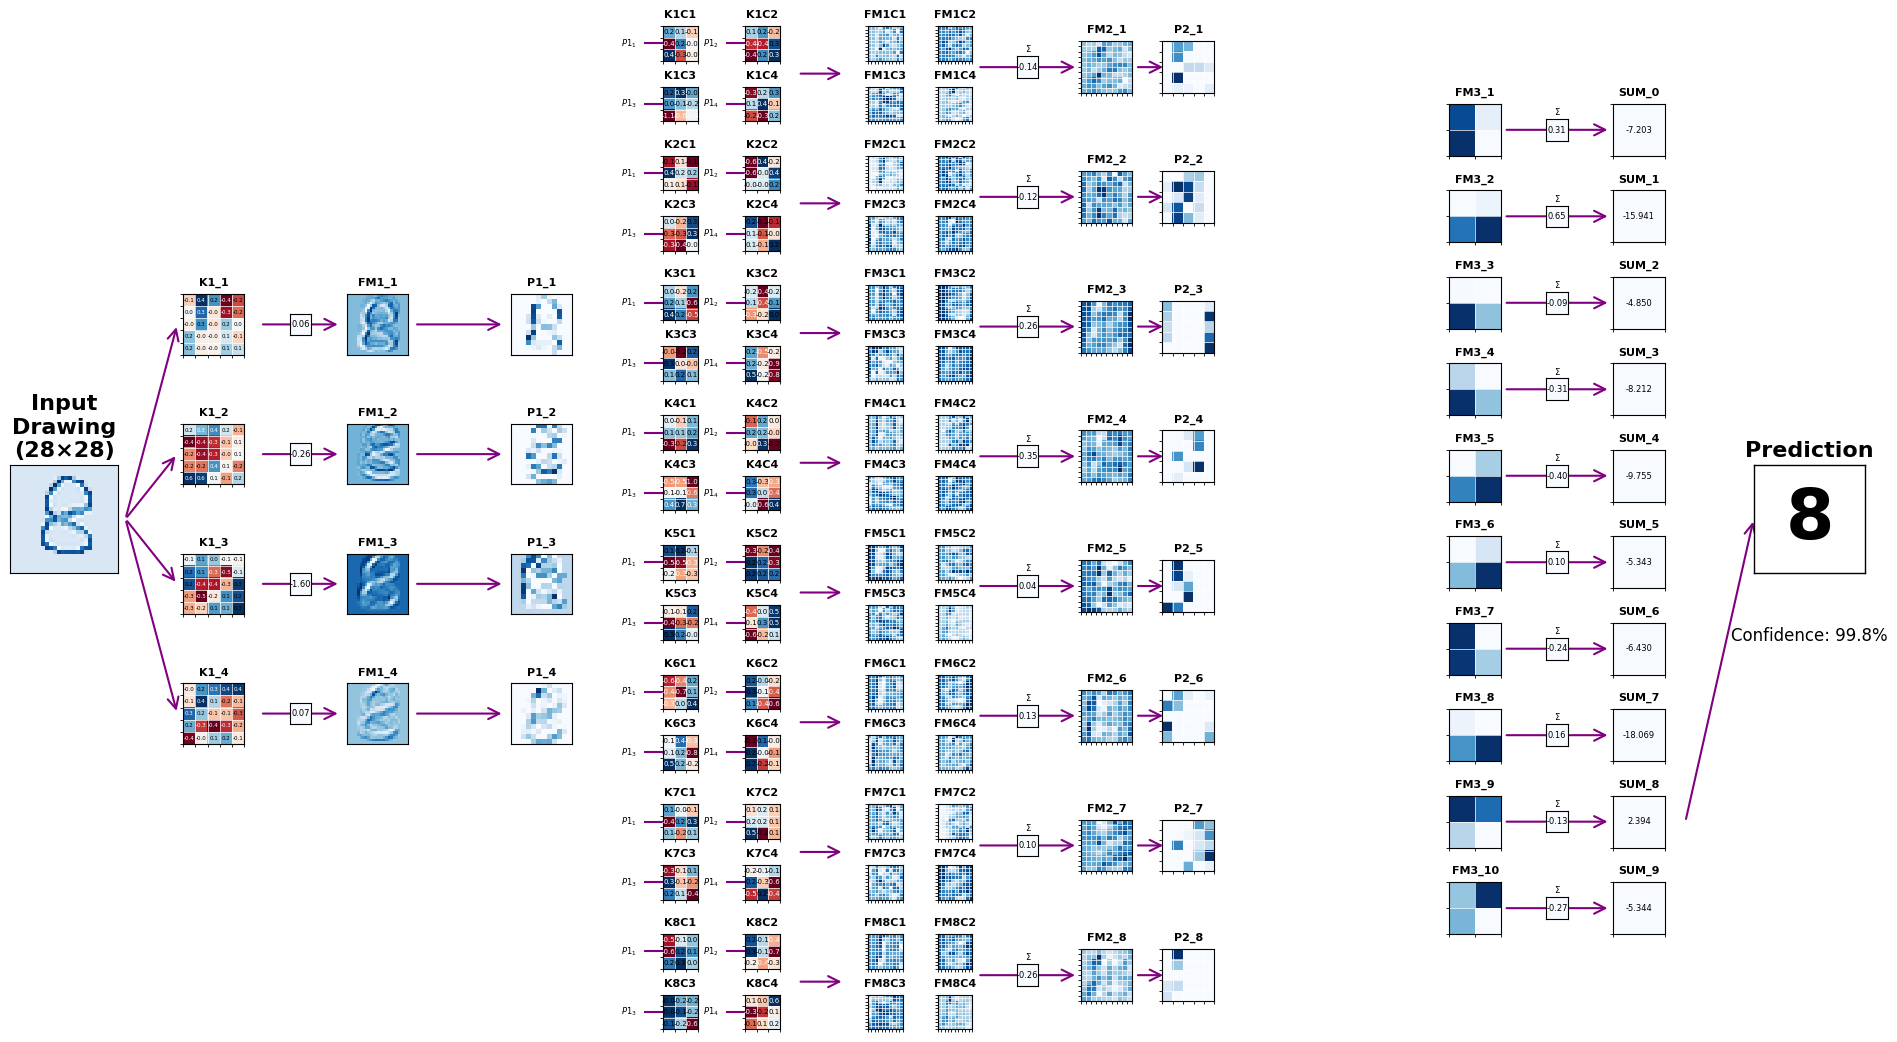

In [1]:
import pygame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy import ndimage
import threading
import time
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
import queue


class MinimalCNN(nn.Module):
    def __init__(self):
        super(MinimalCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride = 1)
        self.conv3 = nn.Conv2d(8, 10, kernel_size=4, stride = 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        conv1 = self.conv1(x)
        pool1 = self.pool(F.relu(conv1))
        conv2 = self.conv2(pool1)
        pool2 = self.pool(F.relu(conv2))
        conv3 = self.conv3(pool2)
        conv3 = self.dropout(conv3)
        sum = torch.sum(conv3, dim=(2, 3))
        out = sum.view(-1, 10)
        return conv1, pool1, conv2, pool2, conv3, sum, out


def load_model():
    model = MinimalCNN()
    model.load_state_dict(torch.load('mnist_cnn_4-8-10.pth', map_location='cpu'))
    model.eval()
    return model


def center_and_normalize_digit(digit_array, target_size=20):
    rows, cols = np.where(digit_array > 0)
    
    if len(rows) == 0:
        return digit_array
    
    min_row, max_row = rows.min(), rows.max()
    min_col, max_col = cols.min(), cols.max()
    
    digit_region = digit_array[min_row:max_row+1, min_col:max_col+1]
    
    height, width = digit_region.shape
    scale = min(target_size / height, target_size / width)
    
    if scale < 1.0:
        new_height = int(height * scale)
        new_width = int(width * scale)
        digit_region = ndimage.zoom(digit_region, (new_height/height, new_width/width))
    
    centered_digit = np.zeros((28, 28))
    
    region_height, region_width = digit_region.shape
    start_row = (28 - region_height) // 2
    start_col = (28 - region_width) // 2
    
    centered_digit[start_row:start_row+region_height, start_col:start_col+region_width] = digit_region
    
    return centered_digit


def calculate_center_of_mass(digit_array):
    rows, cols = np.where(digit_array > 0)
    if len(rows) == 0:
        return 14, 14
    
    weights = digit_array[rows, cols]
    center_row = np.average(rows, weights=weights)
    center_col = np.average(cols, weights=weights)
    
    return center_row, center_col


def fine_tune_centering(digit_array):
    center_row, center_col = calculate_center_of_mass(digit_array)
    
    target_center = 13.5
    shift_row = int(round(target_center - center_row))
    shift_col = int(round(target_center - center_col))
    
    shift_row = max(-10, min(10, shift_row))
    shift_col = max(-10, min(10, shift_col))
    
    if shift_row != 0 or shift_col != 0:
        digit_array = ndimage.shift(digit_array, (shift_row, shift_col), cval=0.0)
    
    return digit_array


def preprocess_drawing(digit_array):
    centered = center_and_normalize_digit(digit_array)
    final = fine_tune_centering(centered)
    
    tensor = torch.FloatTensor(final)
    normalized = (tensor - 0.5) / 0.5
    input_tensor = normalized.unsqueeze(0).unsqueeze(0)
    
    return input_tensor, final


def predict_digit_improved(model, digit_array):
    if np.sum(digit_array) == 0:
        # Return zeros for empty input
        return 0, 0.0, np.ones(10) * 0.1, digit_array, [np.zeros((4, 24, 24)), np.zeros((4, 12, 12)), np.zeros((8, 8, 8)), np.zeros((8, 4, 4)), np.zeros((10, 1, 1)), np.zeros(10)]
    
    input_tensor, processed_array = preprocess_drawing(digit_array)
    
    with torch.no_grad():
        conv1, pool1, conv2, pool2, conv3, sum_out, outputs = model(input_tensor)
        stages = [conv1, pool1, conv2, pool2, conv3, sum_out]
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    return predicted.item(), confidence.item(), probabilities.squeeze().numpy(), processed_array, stages


def apply_convolution(num_kernels, num_channels, weights, input_tensor):
    output_maps = []
    
    # Ensure input_tensor has the right shape and data type
    if len(input_tensor.shape) == 3:
        input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension
    
    # Ensure both tensors have the same data type
    input_tensor = input_tensor.float()
    weights = weights.float()
    
    for i in range(0, num_kernels):
        kernels = []
        for j in range(0, num_channels):
            # Make sure we have the right number of channels
            if j < input_tensor.shape[1]:
                conv_output = F.conv2d(input_tensor[:, j:j+1, :, :], weights[i:i+1, j:j+1, :, :], stride=1)
                conv_output_np = conv_output.squeeze(0).squeeze(0).detach().cpu().numpy()
                kernels.append(conv_output_np)
            else:
                # If we don't have enough input channels, create zeros
                kernels.append(np.zeros((1, 1)))
        output_maps.append(kernels)
    return output_maps


class CNNVisualizationWindow:
    def __init__(self, data_queue):
        self.data_queue = data_queue
        self.root = tk.Tk()
        self.root.title("Real-time CNN Visualization - Full Layout with Arrows")
        self.root.state('zoomed')  # Fullscreen on Windows
        
        # Load model and get filters
        try:
            self.model = load_model()
        except FileNotFoundError:
            print("Could not find 'mnist_cnn_4-8-10.pth' model file")
            self.root.destroy()
            return
            
        # Extract filters from all layers
        self.filters1 = []
        self.filters2 = []
        self.filters3 = []
        
        filters1 = self.model.conv1.weight.data
        filters2 = self.model.conv2.weight.data
        filters3 = self.model.conv3.weight.data
        
        # Extract conv1 filters (4 filters, 1 channel each)
        for i in range(filters1.size(0)):
            channels = []
            for j in range(1):  # 1 channel
                channels.append(filters1[i][j].detach().cpu().numpy())
            self.filters1.append(channels)
        
        # Extract conv2 filters (8 filters, 4 channels each)
        for i in range(filters2.size(0)):
            channels = []
            for j in range(4):  # 4 channels
                channels.append(filters2[i][j].detach().cpu().numpy())
            self.filters2.append(channels)
        
        # Extract conv3 filters (10 filters, 8 channels each)
        for i in range(filters3.size(0)):
            channels = []
            for j in range(8):  # 8 channels
                channels.append(filters3[i][j].detach().cpu().numpy())
            self.filters3.append(channels)
        
        # Get bias values
        self.filter_bias1 = self.model.conv1.bias.data.detach().cpu().numpy()
        self.filter_bias2 = self.model.conv2.bias.data.detach().cpu().numpy()
        self.filter_bias3 = self.model.conv3.bias.data.detach().cpu().numpy()
        
        self.setup_matplotlib()
        self.start_update_loop()
        
    def setup_matplotlib(self):
        # Create matplotlib figure that shows everything at once - much wider to fit prediction box
        plt.ioff()  # Turn off interactive mode
        self.fig = plt.figure(figsize=(22, 10))  # Much wider to ensure prediction box is visible
        
        # Create tkinter canvas - simple approach
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.root)
        self.canvas_widget = self.canvas.get_tk_widget()
        self.canvas_widget.pack(fill=tk.BOTH, expand=True)
        
        # Initialize plot elements
        self.setup_plot_elements()
        
    def plot_matrix(self, ax, matrix, title, cmap='Blues', value_format='.1f', show_grid=True, show_numbers=False, change_color=True, font=-1):
        """Scaled plot_matrix function for live visualization"""
        im = ax.imshow(matrix, cmap=cmap, interpolation='nearest')
        ax.set_title(title, fontsize=8, fontweight='bold')  # Smaller font for dense layout

        if show_grid and matrix.shape[0] <= 10 and matrix.shape[1] <= 10:
            ax.set_xticks(np.arange(-.5, matrix.shape[1], 1), minor=True)
            ax.set_yticks(np.arange(-.5, matrix.shape[0], 1), minor=True)
            ax.grid(which='minor', color='w', linestyle='-', linewidth=0.5)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.set_xticks([])
            ax.set_yticks([])

        if show_numbers and matrix.shape[0] <= 10 and matrix.shape[1] <= 10:
            max_dim = max(matrix.shape[0], matrix.shape[1])
            if font > 0:
                fontsize = font
            elif matrix.shape[0] == 1 and matrix.shape[1] == 1:
                fontsize = 6   # Smaller for dense layout
            elif max_dim <= 3:
                fontsize = 5
            elif max_dim <= 5:
                fontsize = 4
            else:
                fontsize = 3
            for i in range(matrix.shape[0]):
                for j in range(matrix.shape[1]):
                    value = matrix[i, j]
                    text_color = 'white' if (abs(value) > 0.3 and change_color) else 'black'
                    if isinstance(value, (int, np.integer)):
                        value_str = f"{value}"
                    else:
                        value_str = f"{value:{value_format}}"
                    ax.text(j, i, value_str, ha='center', va='center',
                            color=text_color, fontsize=fontsize)
        return ax

    def add_straight_arrow(self, start_x, start_y, end_x, end_y, color='purple', width=3.0):
        """Add arrow between two points with consistent gaps"""
        arrow = patches.FancyArrowPatch(
            (start_x, start_y), (end_x, end_y),
            arrowstyle='->', color=color, linewidth=width,
            connectionstyle='arc3,rad=0',
            shrinkA=2, shrinkB=2,  # Small shrinking for clean appearance
            mutation_scale=20,  # Scaled down for live version
            transform=self.fig.transFigure, zorder=0
        )
        self.fig.add_artist(arrow)

    def add_straight_line(self, start_x, start_y, end_x, end_y, color='purple', width=3.0):
        """Add line between two points"""
        line = Line2D(
            [start_x, end_x], [start_y, end_y],
            color=color, linewidth=width,
            transform=self.fig.transFigure, zorder=0
        )
        self.fig.add_artist(line)
        
    def setup_plot_elements(self):
        """Initialize all plot elements with same layout as static version"""
        self.fig.clear()
        
        # Store axes for updates - same structure as static version
        self.axes = {}
        
        # Use the exact same coordinates as static version, scaled by 0.4 to fit in the figure
        scale = 0.4  # Back to original scale
        
        # Shift everything up to show the bottom parts that are getting cut off
        vertical_shift = 0.35  # Move everything up
        
        input_left = 0.005  # Moved left
        kernel1_base_left = 0.25 * scale  # Moved left
        feature1_base_left = 0.45 * scale  # Moved left
        pooling1_base_left = 0.65 * scale  # Moved left
        kernels2_base_left = 0.85 * scale  # Moved left
        channels2_base_left = 1.10 * scale  # Moved further left
        feature2_base_left = 1.35 * scale  # Moved left
        pooling2_base_left = 1.45 * scale  # Moved left
        feature3_base_left = 1.80 * scale  # Adjusted for new spacing
        out_base_left = 2.00 * scale       # Adjusted for new spacing
        prediction_left = 2.20 * scale     # Adjusted for new spacing

        # Calculate true center position (scaled and shifted)
        sub_height = 0.12 * scale
        v_spacing = 0.02 * scale
        top_edge = (0.85 * scale + sub_height) + vertical_shift
        bottom_edge = ((0.85 * scale - (3 * 0.3 * scale)) - (sub_height + v_spacing)) + vertical_shift
        true_center = (top_edge + bottom_edge) / 2

        # Center input and prediction boxes
        box_height = 0.25 * scale
        centered_bottom = true_center - box_height / 2

        # Create input axis
        input_width = 0.25 * scale
        self.axes['input'] = self.fig.add_axes([input_left, centered_bottom, input_width, box_height])
        
        # Create all other axes exactly like static version
        self.axes['kernel1'] = []
        self.axes['feature1'] = []
        self.axes['pool1'] = []
        self.axes['kernel2_channels'] = []  # Store 2x2 grids for each filter
        self.axes['channels2'] = []  # Store 2x2 grids for feature maps
        self.axes['feature2'] = []
        self.axes['pool2'] = []
        self.axes['feature3'] = []
        self.axes['sum'] = []
        
        # Layer 1: 4 filters - same as static but shifted
        for row in range(4):
            left_kernel = kernel1_base_left
            left_feature = feature1_base_left
            left_pooling = pooling1_base_left
            bottom = (0.77 * scale - (row * 0.3 * scale)) + vertical_shift

            # Plot kernel
            ax_filter = self.fig.add_axes([left_kernel, bottom, 0.14 * scale, 0.14 * scale])
            self.axes['kernel1'].append(ax_filter)

            # Plot corresponding feature map
            ax_output = self.fig.add_axes([left_feature, bottom, 0.14 * scale, 0.14 * scale])
            self.axes['feature1'].append(ax_output)

            # Plot pooled feature maps
            ax_pooling = self.fig.add_axes([left_pooling, bottom, 0.14 * scale, 0.14 * scale])
            self.axes['pool1'].append(ax_pooling)

        # Layer 2: kernels and channels in 4 vertical 2x2 blocks - same as static but shifted
        for block_num in range(8):
            block_kernel_axes = []
            block_output_axes = []
            block_top = (1.45 * scale - (block_num * 0.3 * scale)) + vertical_shift  # Back to original spacing between sets

            for sub_row in range(2):
                for sub_col in range(2):
                    f = sub_row * 2 + sub_col
                    sub_width = 0.08 * scale      
                    sub_height = 0.08 * scale     
                    h_spacing_kernels = 0.02 * scale  # Reduced from 0.04 to make squares closer
                    h_spacing_features = 0.005 * scale  # Reduced from 0.01 to make squares closer 
                    v_spacing = 0.06 * scale          # Increased from 0.04 to 0.06 for more clearance between titles and boxes

                    left_kernel = kernels2_base_left + sub_col * (sub_width + h_spacing_kernels)
                    left_feature = channels2_base_left + sub_col * (sub_width + h_spacing_features)
                    bottom = block_top - sub_row * (sub_height + v_spacing)

                    # Plot kernel
                    ax_filter = self.fig.add_axes([left_kernel, bottom, sub_width, sub_height])
                    block_kernel_axes.append(ax_filter)

                    # Plot corresponding feature map
                    ax_output = self.fig.add_axes([left_feature, bottom, sub_width, sub_height])
                    block_output_axes.append(ax_output)

            self.axes['kernel2_channels'].append(block_kernel_axes)
            self.axes['channels2'].append(block_output_axes)

        # Layer 2: feature maps and pooling in 1 column of 8 - same as static but shifted
        for row in range(8):
            bottom = (1.375 * scale - (row * 0.3 * scale)) + vertical_shift  # Back to original spacing between sets
            sub_height = 0.12 * scale
            left_feature = feature2_base_left
            left_pooling = pooling2_base_left

            # Plot feature map
            ax_output = self.fig.add_axes([left_feature, bottom, 0.12 * scale, sub_height])
            self.axes['feature2'].append(ax_output)

            # Plot pooled feature map
            ax_pooling = self.fig.add_axes([left_pooling, bottom, 0.12 * scale, sub_height])
            self.axes['pool2'].append(ax_pooling)

        # Layer 3: same as static but shifted
        for row in range(10):
            bottom = (1.23 * scale - (row * 0.2 * scale)) + vertical_shift
            sub_height = 0.12 * scale
            left_feature = feature3_base_left

            # Plot conv3 output
            ax_feature = self.fig.add_axes([left_feature, bottom, 0.12 * scale, sub_height])
            self.axes['feature3'].append(ax_feature)

            # Plot output
            ax_out = self.fig.add_axes([out_base_left, bottom, 0.12 * scale, sub_height])
            self.axes['sum'].append(ax_out)

        # Prediction box - account for figure aspect ratio to make it truly square
        figure_aspect_ratio = 22 / 10  # Our figure is 22x10
        prediction_bottom = centered_bottom
        prediction_width = (box_height / figure_aspect_ratio) * 1.2  # Previous approach but slightly wider
        prediction_height = box_height  # Keep original height
        self.axes['prediction'] = self.fig.add_axes([prediction_left, prediction_bottom, prediction_width, prediction_height])

        # Track dynamic prediction arrow
        self.prediction_arrow = None
        
        # Initialize static elements (kernels, bias values, and arrows)
        self.draw_static_elements()
        
        # Initialize with empty data
        self.update_visualization_data(np.zeros((28, 28)))
        
    def draw_static_elements(self):
        """Draw static elements that don't change (kernels, bias values, arrows)"""
        # Draw Layer 1 kernels
        for i, ax in enumerate(self.axes['kernel1']):
            self.plot_matrix(ax, self.filters1[i][0], f'K1_{i+1}', cmap='RdBu', show_numbers=True)
        
        # Draw Layer 2 kernels
        for block_num, block_axes in enumerate(self.axes['kernel2_channels']):
            for ch, ax in enumerate(block_axes):
                self.plot_matrix(ax, self.filters2[block_num][ch], f'K{block_num+1}C{ch+1}', cmap='RdBu', show_numbers=True)
        
        # Add all the arrows and annotations from the static version
        self.add_arrows_and_annotations()
        
    def add_arrows_and_annotations(self):
        """Add arrows, bias values, and annotations like in the static version"""
        
        # NEW: Add arrows from input to each of the first four kernels
        input_bbox = self.axes['input'].get_position()
        input_right_x = input_bbox.x0 + input_bbox.width - 0.02  # Move origin further left from input box
        input_center_y = input_bbox.y0 + input_bbox.height / 2
        
        for i, ax_kernel in enumerate(self.axes['kernel1']):
            kernel_bbox = ax_kernel.get_position()
            kernel_left_x = kernel_bbox.x0 - 0.005  # Much closer to kernel so arrowhead points directly at it
            kernel_center_y = kernel_bbox.y0 + kernel_bbox.height / 2
            
            # Add arrow from input to this kernel
            self.add_straight_arrow(input_right_x, input_center_y, kernel_left_x, kernel_center_y, color='purple', width=1.5)

        # Add proper arrows from each Layer 1 kernel to its corresponding feature map (with longer arrows)
        for i, ax_filter in enumerate(self.axes['kernel1']):
            ax_output = self.axes['feature1'][i]
            # Start slightly after the right edge of the kernel
            kernel_right_x = ax_filter.get_position().x0 + ax_filter.get_position().width + 0.01  # Small gap
            kernel_center_y = ax_filter.get_position().y0 + ax_filter.get_position().height / 2
            # End moderately inside the feature map to make arrowhead longer but not too long
            feature_left_x = ax_output.get_position().x0 + 0.01  # Moderate distance into the target box
            feature_center_y = ax_output.get_position().y0 + ax_output.get_position().height / 2
            # Create arrow with consistent gap
            self.add_straight_arrow(kernel_right_x, kernel_center_y, feature_left_x, feature_center_y, color='purple', width=1.5)
            
            # Add bias value on the arrow
            bias_value = self.filter_bias1[i]
            bias_matrix = np.array([[bias_value]])
            bias_width = 0.024  # Scaled down
            bias_height = 0.02   # Scaled down
            bias_center_x = ((kernel_right_x + feature_left_x) / 2) - bias_width / 2
            bias_center_y = ((kernel_center_y + feature_center_y) / 2) - bias_height / 2
            ax_bias = self.fig.add_axes([bias_center_x, bias_center_y, bias_width, bias_height])
            self.plot_matrix(ax_bias, bias_matrix, '', show_numbers=True, value_format='.2f', show_grid=False, change_color=False, font=6)

        # Add proper arrows from each Layer 1 feature map to its corresponding pooling map (with longer arrows)
        for i, ax_output in enumerate(self.axes['feature1']):
            ax_pooling = self.axes['pool1'][i]
            # Start earlier from inside the feature map to make left side longer
            feature_right_x = ax_output.get_position().x0 + ax_output.get_position().width - 0.01  # Start from inside the feature map
            feature_center_y = ax_output.get_position().y0 + ax_output.get_position().height / 2
            # End moderately inside the pooling map to make arrowhead side longer but not too long
            pool_left_x = ax_pooling.get_position().x0 + 0.01  # Moderate distance into the target box
            pool_center_y = ax_pooling.get_position().y0 + ax_pooling.get_position().height / 2
            # Create arrow with consistent gap
            self.add_straight_arrow(feature_right_x, feature_center_y, pool_left_x, pool_center_y, color='purple', width=1.5)

        # Add lines from pooled layer 1 to layer 2 kernels with labels (shorter lines)
        for block_num, block_kernel_axes in enumerate(self.axes['kernel2_channels']):
            for ch, ax in enumerate(block_kernel_axes):
                # Add shorter line from corresponding P1 output
                line_y = ax.get_position().y0 + ax.get_position().height / 2
                line_x_start = ax.get_position().x0 - 0.01  # Shorter line
                line_x_end = ax.get_position().x0
                self.add_straight_line(line_x_start, line_y, line_x_end, line_y, color='purple', width=1.5)

                # Add text label closer to the kernel
                text_x = line_x_start - 0.004  # Closer to avoid overlap
                text_y = line_y
                label_text = 'P1_' + str(ch+1)
                self.fig.text(text_x, text_y, '$' + label_text + '$', fontsize=6, verticalalignment='center', horizontalalignment='right')

        # Add proper arrows from Layer 2 kernel blocks to channel feature maps (with small gap after kernel block)
        for block_num, block_kernel_axes in enumerate(self.axes['kernel2_channels']):
            # Get the right center of the 2x2 kernel block
            ax_k0 = block_kernel_axes[0]
            ax_k3 = block_kernel_axes[3]
            kernel_block_x = ax_k3.get_position().x0 + ax_k3.get_position().width + 0.01  # Small gap
            kernel_block_y = (ax_k0.get_position().y0 + ax_k3.get_position().y0 + ax_k3.get_position().height) / 2

            # Get the left center of the 2x2 feature (channels) block
            block_output_axes = self.axes['channels2'][block_num]
            ax_f0 = block_output_axes[0]
            ax_f3 = block_output_axes[3]
            filter_block_x = ax_f0.get_position().x0 - 0.004  # Scaled down
            filter_block_y = (ax_f0.get_position().y0 + ax_f3.get_position().y0 + ax_f3.get_position().height) / 2

            # Create arrow with consistent gap
            self.add_straight_arrow(kernel_block_x, kernel_block_y, filter_block_x, filter_block_y, color='purple', width=1.5)

        # Add arrows from each 2x2 channel block to its corresponding feature map with proper arrows (perfectly horizontal)
        for block_num, block_output_axes in enumerate(self.axes['channels2']):
            # Get the right center of the 2x2 channel block
            ax_c0 = block_output_axes[0]
            ax_c3 = block_output_axes[3]
            channel_block_x = ax_c3.get_position().x0 + ax_c3.get_position().width - 0.005  # Start slightly inside the block

            # Get the left center of the corresponding feature map
            ax_feature = self.axes['feature2'][block_num]
            feature_block_x = ax_feature.get_position().x0 + 0.01  # End slightly into the feature map
            feature_block_y = ax_feature.get_position().y0 + ax_feature.get_position().height / 2
            
            # Use the same Y coordinate for both start and end to make arrow perfectly horizontal
            channel_block_y = feature_block_y

            # Add arrow with proper arrowhead and consistent gap
            self.add_straight_arrow(channel_block_x, channel_block_y, feature_block_x, feature_block_y, color='purple', width=1.5)
            
            # Add bias value on the arrow
            bias_value = self.filter_bias2[block_num]
            bias_matrix = np.array([[bias_value]])
            bias_width = 0.024  # Scaled down
            bias_height = 0.02   # Scaled down
            bias_center_x = ((channel_block_x + feature_block_x) / 2) - bias_width / 2
            bias_center_y = ((channel_block_y + feature_block_y) / 2) - bias_height / 2
            ax_bias = self.fig.add_axes([bias_center_x, bias_center_y, bias_width, bias_height])
            self.plot_matrix(ax_bias, bias_matrix, '', show_numbers=True, value_format='.2f', show_grid=False, change_color=False, font=6)
            
            # Add sigma symbol positioned properly centered over the bias box
            sigma_x = ((channel_block_x + feature_block_x) / 2)  # Center of the bias box
            sigma_y = ((channel_block_y + feature_block_y) / 2) + 0.012  # Slightly above the bias box center
            self.fig.text(sigma_x, sigma_y, 'Σ', fontsize=6, verticalalignment='bottom', horizontalalignment='center')

        # Add proper arrows from each Layer 2 pooling map to its corresponding feature map (with small gap after feature map)
        for i, ax_output in enumerate(self.axes['feature2']):
            ax_pooling = self.axes['pool2'][i]
            # Start slightly after the right edge of the feature map
            feature_right_x = ax_output.get_position().x0 + ax_output.get_position().width + 0.005  # Smaller gap
            feature_center_y = ax_output.get_position().y0 + ax_output.get_position().height / 2
            # End closer to the pooling map  
            pool_left_x = ax_pooling.get_position().x0 - 0.002  # Closer to the box
            pool_center_y = ax_pooling.get_position().y0 + ax_pooling.get_position().height / 2
            # Create arrow with consistent gap - but reverse the direction!
            self.add_straight_arrow(pool_left_x, pool_center_y, feature_right_x, feature_center_y, color='purple', width=1.5)

        # Add proper arrows from Layer 3 feature maps directly to SUM outputs (with longer arrows on both sides)
        for i, ax_feature in enumerate(self.axes['feature3']):
            ax_out = self.axes['sum'][i]
            # Start from inside the FM3 box to make left side longer
            feature_right_x = ax_feature.get_position().x0 + ax_feature.get_position().width - 0.01  # Start from inside the box
            feature_center_y = ax_feature.get_position().y0 + ax_feature.get_position().height / 2
            # End moderately into the SUM box to make arrowhead visible
            sum_left_x = ax_out.get_position().x0 + 0.01  # End less far into the target box to show arrowhead
            sum_center_y = ax_out.get_position().y0 + ax_out.get_position().height / 2
            # Create arrow with consistent gap
            self.add_straight_arrow(feature_right_x, feature_center_y, sum_left_x, sum_center_y, color='purple', width=1.5)
            
            # Add bias value on the arrow
            bias_value = self.filter_bias3[i]
            bias_matrix = np.array([[bias_value]])
            bias_width = 0.024  # Scaled down
            bias_height = 0.02   # Scaled down
            bias_center_x = ((feature_right_x + sum_left_x) / 2) - bias_width / 2
            bias_center_y = ((feature_center_y + sum_center_y) / 2) - bias_height / 2
            ax_bias = self.fig.add_axes([bias_center_x, bias_center_y, bias_width, bias_height])
            self.plot_matrix(ax_bias, bias_matrix, '', show_numbers=True, value_format='.2f', show_grid=False, change_color=False, font=6)

            # Add sigma symbol positioned properly centered over the bias box
            sigma_x = ((feature_right_x + sum_left_x) / 2)  # Center of the bias box
            sigma_y = ((feature_center_y + sum_center_y) / 2) + 0.012  # Slightly above the bias box center
            self.fig.text(sigma_x, sigma_y, 'Σ', fontsize=6, verticalalignment='bottom', horizontalalignment='center')
        
    def update_visualization_data(self, digit_array):
        """Update the visualization with new data"""
        predicted_digit, confidence, _, processed_array, stages = predict_digit_improved(self.model, digit_array)
        
        # Clear only the dynamic elements that need to be redrawn
        dynamic_axes = ['input', 'feature1', 'pool1', 'channels2', 'feature2', 'pool2', 'feature3', 'sum', 'prediction']
        
        # Update input display
        self.axes['input'].clear()
        self.plot_matrix(self.axes['input'], processed_array, 'Input\nDrawing\n(28×28)', show_numbers=False)
        self.axes['input'].set_title('Input\nDrawing\n(28×28)', fontsize=16, fontweight='bold')  # Scaled down from 80
        
        # Extract stage data with proper dimension handling
        if len(stages) >= 6:
            def extract_tensor_data(tensor):
                if hasattr(tensor, 'detach'):
                    tensor = tensor.detach().cpu()
                if hasattr(tensor, 'numpy'):
                    tensor = tensor.numpy()
                # Remove batch dimension if present
                if len(tensor.shape) > 3 and tensor.shape[0] == 1:
                    tensor = tensor[0]
                elif len(tensor.shape) > 2 and tensor.shape[0] == 1:
                    tensor = tensor[0]
                elif len(tensor.shape) > 1 and tensor.shape[0] == 1:
                    tensor = tensor[0]
                return tensor
            
            conv1_out = extract_tensor_data(stages[0])
            pool1_out = extract_tensor_data(stages[1])
            conv2_out = extract_tensor_data(stages[2])
            pool2_out = extract_tensor_data(stages[3])
            conv3_out = extract_tensor_data(stages[4])
            sum_out = extract_tensor_data(stages[5])
            
            # Calculate conv2 channel outputs like in static version
            # Make sure stages[1] (pool1_out) has proper tensor format
            pool1_tensor = stages[1]
            if not isinstance(pool1_tensor, torch.Tensor):
                pool1_tensor = torch.tensor(pool1_out).float()
            else:
                pool1_tensor = pool1_tensor.float()
            if len(pool1_tensor.shape) == 3:
                pool1_tensor = pool1_tensor.unsqueeze(0)  # Add batch dimension
            
            try:
                channels2_data = apply_convolution(8, 4, self.model.conv2.weight.data, pool1_tensor)
            except Exception as e:
                print(f"Error in apply_convolution: {e}")
                # Create dummy data if convolution fails
                channels2_data = [[np.zeros((8, 8)) for _ in range(4)] for _ in range(8)]
            
            # Update Layer 1 feature maps and pooling
            for i in range(min(4, len(self.axes['feature1']))):
                # Feature map 1
                self.axes['feature1'][i].clear()
                if len(conv1_out.shape) >= 3 and i < conv1_out.shape[0]:
                    self.plot_matrix(self.axes['feature1'][i], conv1_out[i], f'FM1_{i+1}', show_numbers=False)
                
                # Pool 1
                self.axes['pool1'][i].clear()
                if len(pool1_out.shape) >= 3 and i < pool1_out.shape[0]:
                    self.plot_matrix(self.axes['pool1'][i], pool1_out[i], f'P1_{i+1}', cmap='Blues', show_numbers=False)
            
            # Update Layer 2 channel feature maps
            for block_num, block_axes in enumerate(self.axes['channels2']):
                if block_num < len(channels2_data):
                    for ch, ax in enumerate(block_axes):
                        ax.clear()
                        if ch < len(channels2_data[block_num]):
                            self.plot_matrix(ax, channels2_data[block_num][ch], f'FM{block_num+1}C{ch+1}', show_numbers=False)
            
            # Update Layer 2 feature maps and pooling
            for i in range(min(8, len(self.axes['feature2']))):
                # Feature map 2
                self.axes['feature2'][i].clear()
                if len(conv2_out.shape) >= 3 and i < conv2_out.shape[0]:
                    self.plot_matrix(self.axes['feature2'][i], conv2_out[i], f'FM2_{i+1}', show_numbers=False)
                
                # Pool 2
                self.axes['pool2'][i].clear()
                if len(pool2_out.shape) >= 3 and i < pool2_out.shape[0]:
                    self.plot_matrix(self.axes['pool2'][i], pool2_out[i], f'P2_{i+1}', cmap='Blues', show_numbers=False)
            
            # Update Layer 3
            for i in range(min(10, len(self.axes['feature3']))):
                # Feature map 3
                self.axes['feature3'][i].clear()
                if len(conv3_out.shape) >= 3 and i < conv3_out.shape[0]:
                    self.plot_matrix(self.axes['feature3'][i], conv3_out[i], f'FM3_{i+1}')
                
                # Sum output
                self.axes['sum'][i].clear()
                if len(sum_out.shape) >= 1 and i < len(sum_out):
                    value = sum_out[i] if len(sum_out.shape) >= 1 else sum_out
                    out_value = np.array([[value]])
                    self.plot_matrix(self.axes['sum'][i], out_value, f'SUM_{i}', show_numbers=True, value_format='.3f', cmap='Blues', change_color=False)

        # Update prediction
        self.axes['prediction'].clear()
        self.axes['prediction'].text(0.5, 0.5, str(predicted_digit), ha='center', va='center',
                                   fontsize=50, fontweight='bold', transform=self.axes['prediction'].transAxes)  # Scaled down from 250
        self.axes['prediction'].set_xlim(0, 1)
        self.axes['prediction'].set_ylim(0, 1)
        self.axes['prediction'].set_xticks([])
        self.axes['prediction'].set_yticks([])
        self.axes['prediction'].set_title('Prediction', fontsize=16, fontweight='bold')  # Scaled down from 60

        # Add border
        for spine in self.axes['prediction'].spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1)  # Scaled down from 2

        # Remove existing confidence text
        for text in self.fig.texts[:]:
            if '%' in str(text.get_text()):
                text.remove()
        
        # Add confidence text
        confidence_percentage = confidence * 100
        pred_bbox = self.axes['prediction'].get_position()
        pred_center_x = (pred_bbox.x0 + pred_bbox.x1) / 2
        confidence_y = pred_bbox.y0 - 0.05
        
        self.fig.text(pred_center_x, confidence_y, f'Confidence: {confidence_percentage:.1f}%',
                     ha='center', va='top', fontsize=12)  # Scaled down from 60
        
        # Add arrow from max sum to prediction (dynamic based on current max)
        if len(sum_out) > 0:
            # Remove existing prediction arrow if it exists
            if self.prediction_arrow is not None:
                self.prediction_arrow.remove()
                self.prediction_arrow = None
            
            max_index = np.argmax(sum_out) if len(sum_out.shape) >= 1 else 0
            if max_index < len(self.axes['sum']):
                ax_out = self.axes['sum'][max_index]
                line_y_start = ax_out.get_position().y0 + ax_out.get_position().height / 2
                line_y_end = pred_bbox.y0 + pred_bbox.height / 2
                line_x_start = ax_out.get_position().x0 + ax_out.get_position().width + 0.01  # Small gap
                line_x_end = pred_bbox.x0
                
                # Create and store the prediction arrow with consistent gap
                self.prediction_arrow = patches.FancyArrowPatch(
                    (line_x_start, line_y_start), (line_x_end, line_y_end),
                    arrowstyle='->', color='purple', linewidth=1.5,
                    connectionstyle='arc3,rad=0',
                    shrinkA=2, shrinkB=2,  # Small shrinking for clean appearance
                    mutation_scale=20,
                    transform=self.fig.transFigure, zorder=0
                )
                self.fig.add_artist(self.prediction_arrow)
        
        # Redraw
        self.canvas.draw()
        
    def start_update_loop(self):
        """Start the update loop that checks for new data"""
        def update():
            try:
                while True:
                    digit_array = self.data_queue.get_nowait()
                    self.update_visualization_data(digit_array)
            except queue.Empty:
                pass
            
            # Schedule next update - ULTRA FAST: 1ms intervals!
            self.root.after(1, update)  # Changed from 50ms to 1ms
        
        update()
        
    def run(self):
        self.root.mainloop()


class DrawingWindow:
    def __init__(self, data_queue):
        self.data_queue = data_queue
        
        # Initialize pygame
        pygame.init()
        self.WIDTH, self.HEIGHT = 560, 560
        self.BG_COLOR = (255, 255, 255)
        self.running = True
        self.grid_array = []
        self.digit_array = np.zeros((28, 28))
        
        # Initialize pygame window
        self.window = pygame.display.set_mode((self.WIDTH, self.HEIGHT))
        pygame.display.set_caption("Draw Here - Ultra Fast CNN Visualization with Arrows")
        self.window.fill(self.BG_COLOR)
        
        # Drawing state - ULTRA FAST: immediate updates!
        self.last_update_time = 0
        self.update_interval = 0.001  # Changed from 0.1s to 1ms for ultra-fast updates
        
        self.setup_grid()
        
    def setup_grid(self):
        block_size = int(self.WIDTH/28)
        self.grid_array = []
        
        for i in range(28):
            for j in range(28):
                grid_block = pygame.Rect(i * block_size, j * block_size, block_size, block_size)
                color = (255, 255, 255)
                self.grid_array.append((grid_block, color))
    
    def get_digit_array(self):
        digit = np.zeros((28, 28))
        
        for row in range(28):
            for col in range(28):
                index = col * 28 + row
                rect, color = self.grid_array[index]
                
                if color == (0, 0, 0):
                    digit[row, col] = 0.9
        
        return digit
    
    def clear_grid(self):
        for i in range(len(self.grid_array)):
            rect, _ = self.grid_array[i]
            self.grid_array[i] = (rect, (255, 255, 255))
    
    def draw_rectangles(self):
        for rect, color in self.grid_array:
            pygame.draw.rect(self.window, color, rect)
            pygame.draw.rect(self.window, (200, 200, 200), rect, 1)
    
    def run(self):
        clock = pygame.time.Clock()
        
        print("- Click and drag to draw")
        print("- Press SPACE to clear")
        print("- Press ESC to exit")
        print("- Live visualization with arrows and biases in other window")
        
        while self.running:
            current_time = time.time()
            
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    self.running = False
                    
                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_ESCAPE:
                        self.running = False
                    elif event.key == pygame.K_SPACE:
                        self.clear_grid()
                        self.digit_array = np.zeros((28, 28))
                        # Send cleared array immediately
                        try:
                            # Clear the queue first to avoid lag
                            while not self.data_queue.empty():
                                try:
                                    self.data_queue.get_nowait()
                                except queue.Empty:
                                    break
                            self.data_queue.put_nowait(self.digit_array.copy())
                        except queue.Full:
                            pass
            
            # Handle drawing
            if pygame.mouse.get_pressed()[0]:
                mouse_pos = pygame.mouse.get_pos()
                for index, (rect, color) in enumerate(self.grid_array):
                    if rect.collidepoint(mouse_pos):
                        self.grid_array[index] = (rect, (0, 0, 0))
            
            # Send updates ultra frequently - changed condition for maximum speed
            if current_time - self.last_update_time > self.update_interval:
                new_digit_array = self.get_digit_array()
                if not np.array_equal(new_digit_array, self.digit_array):
                    self.digit_array = new_digit_array
                    # Send to visualization window - clear queue first to prevent lag
                    try:
                        # Clear old updates to keep only the latest
                        while not self.data_queue.empty():
                            try:
                                self.data_queue.get_nowait()
                            except queue.Empty:
                                break
                        self.data_queue.put_nowait(self.digit_array.copy())
                    except queue.Full:
                        # If queue is full, skip this update
                        pass
                self.last_update_time = current_time
            
            # Draw pygame window
            self.window.fill(self.BG_COLOR)
            self.draw_rectangles()
            pygame.display.flip()
            clock.tick(120)  # Increased from 60 FPS to 120 FPS for smoother drawing
        
        pygame.quit()


def main():
    try:
        # Create communication queue - UNLIMITED SIZE for maximum speed
        data_queue = queue.Queue()  # Removed maxsize limit for ultra-fast updates
        
        # Start visualization window in separate thread
        def run_viz_window():
            viz_window = CNNVisualizationWindow(data_queue)
            viz_window.run()
        
        viz_thread = threading.Thread(target=run_viz_window, daemon=True)
        viz_thread.start()
        
        # Reduced initialization delay for faster startup
        time.sleep(0.5)  # Reduced from 1 second to 0.5 seconds
        
        # Run drawing window in main thread
        drawing_window = DrawingWindow(data_queue)
        drawing_window.run()
        
    except FileNotFoundError:
        print("Could not find 'mnist_cnn_4-8-10.pth' model file")
        print("Make sure the CNN model is in the same directory")
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()